In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

### import tainter model

In [2]:
import tainter.model.methods as tm
from tainter.cluster.parameter_setup import generate_parameters
from tainter.cluster.parameter_scan_odeint import parameter_scan, process_output
from tainter.f2_plot_stochastic import fig2_stochastic_simulations
from tainter.f3_plot_ensemble_with_approx import fig3_stochastic_ensemble_and_macroscopic_approximation
from tainter.f3b_plot_trajectories import fig3b_administrator_trajectories
from tainter.f4_plot_parameter_analysis import fig4_parameter_analysis


## Threshold, Access and Energy Production

In the initial network, all nodes are uncoordinated workers
$N = N_L$, therefore the total energy production of the initial network is $E=a~N^\psi$, where $\psi$ is the marginal return of investment for uncoordinated workers, since the per capita enegy production is defined as $E_{cap} = \frac{E}{N}$, initially we have $E_{cap,~init} = a~\frac{N^\psi}{N}$. To satisfy $E_{cap,~init} = 1$, resource access ($a$) has to be $a=\frac{N}{N^\psi}$. This can be interpreted as a baseline efficiency of the workers $\geq 1$ to satisfy their needs.

We then assume that the energy in the network is homegenously re-distributed after production and no additional administrator is selected if $E_{cap} \geq 1$

In [3]:
def calculate_initial_energy_production(N, mri_l):
    """
    calculate the amount of per capita energy production at the initial stage
    of the network, when all nodes are uncoordinated workers, if access
    to the resources is equal to 1
    """
    return N ** mri_l / N


def calculate_initial_resource_access(N, mri_l):
    """
    scales the resource access of the network so that it ensures that the initial
    per capita energy production without coordinated workers equals 1.
    """
    return 1 / calculate_initial_energy_production(N, mri_l)

In [20]:
# define and create directories if not existing
data = "../publication_data"
output = "../results"
os.makedirs(output, exist_ok=True)

# general parameters
SEED = 651
plot_time = 5000
max_runtime = 10000

# simulation parameters (for all figures)
network="erdos"
network_size = 400
rho = 0.02
elasticity_l = 0.75
elasticity_c = 0.75
productivity_c = 1.05
shock_alpha = 15
shock_beta = 1

first_admin = "highest degree"
choice_next_admin = "topcoordinated"

# figure 2 and 3
exploration_scenarios = [0, 0.00275,  0.02]  # must always be a list of 3

# figure 3
ensemble_data = f"{data}/ensemble/"
use_pre_simulated_data_fig3 = True  # uses pre simulated data to generate plot
iterations = 100  # needs to be increased but will take some time

# figure 4
use_pre_simulated_data_fig4 = True
par_scan_output = f"{data}/parameter_analysis/"


#### play with the simulation

Ecap: 1.0
# 0 Number of nodes: 400 mean degree: 8.32


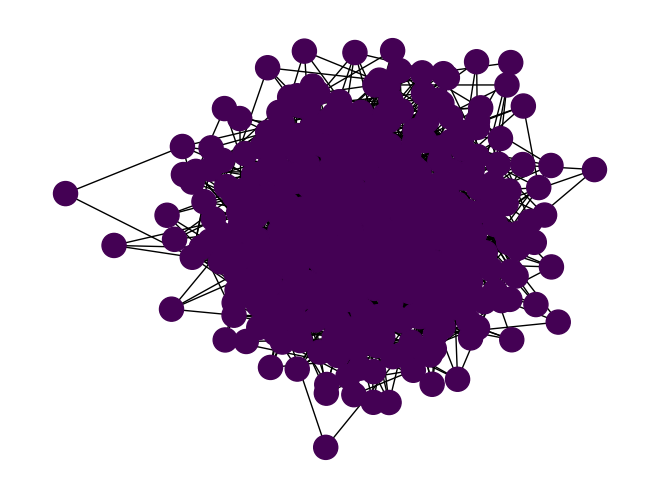

In [5]:
N_coordinated_workers = 10
t = 0
access = calculate_initial_resource_access(network_size, elasticity_l)
A, L, C, positions, E_cap, tmax, ainit, A_exp, L_exp, C_exp, Admin = tm.init(
    N=network_size, 
    a=access, 
    elasticity_l=elasticity_l, 
    elasticity_c=elasticity_c, 
    productivity_c=productivity_c,
    tmax=max_runtime
)
G = tm.construct_network(
    network=network, 
    N=network_size, 
    p=rho
)

ecap = tm.energy_out_capita(
    a=access, 
    L=L, 
    C=C, 
    elasticity_l=elasticity_l, 
    elasticity_c=elasticity_c, 
    productivity_c=productivity_c, 
    N=network_size
)


print(f"Ecap: {round(ecap,2)}")
tm.print_graph(t, A, C, L, G, positions, network_size)

#### response to shocks

The following simulation changes the state of nodes (workers/administrators) in response to random disruptions in the energy availability. If the available energy drops below a threshold, a worker in the influence of an administrator is coordinated to become another administrator.

time: 1, Ecap after network update: 1.064425119171922
# 0 Number of nodes: 400 mean degree: 8.32


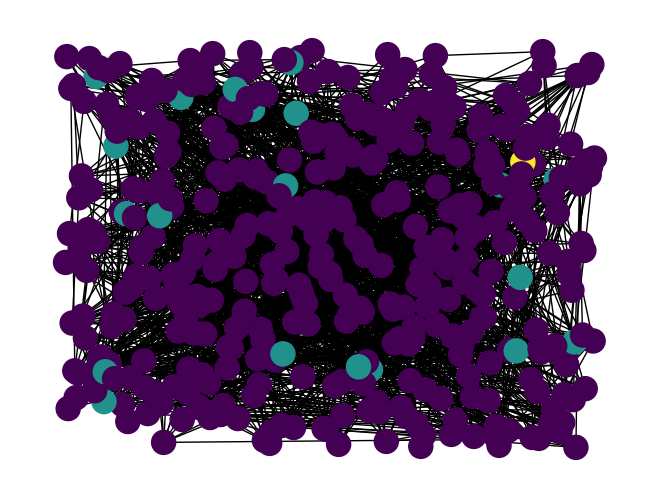

In [6]:
network_update = False
while not network_update:
    t += 1
    shock = tm.shock(shock_alpha, shock_beta)
    access_after_shock = access * (1 - shock)

    # ecap after shock
    ecap = tm.energy_out_capita(
        access_after_shock, L, C, elasticity_l, elasticity_c, 
        productivity_c, network_size)

    print(f"time: {t}, Ecap = {round(ecap, 2)} < {1}", end="\r")
    if ecap < 1:
        Admin = tm.select_Admin(G, A, L, C, first_admin, choice_next_admin)

        # if no Admin is selected, there is no need to update the network
        if Admin != None:
            L, C, A = tm.update_network(A, L, C, Admin, G)

        ecap = tm.energy_out_capita(
            access_after_shock, L, C, elasticity_l, elasticity_c, 
            productivity_c, network_size)

        print(f"time: {t}, Ecap after network update: {ecap}")

        tm.print_graph(0, A, C, L, G, positions, network_size, layout="fixed")

        network_update = True

## Stochastic Simulation

#### Figure 2 

executed scenario with exploration = 0
executed scenario with exploration = 0.00275
executed scenario with exploration = 0.02


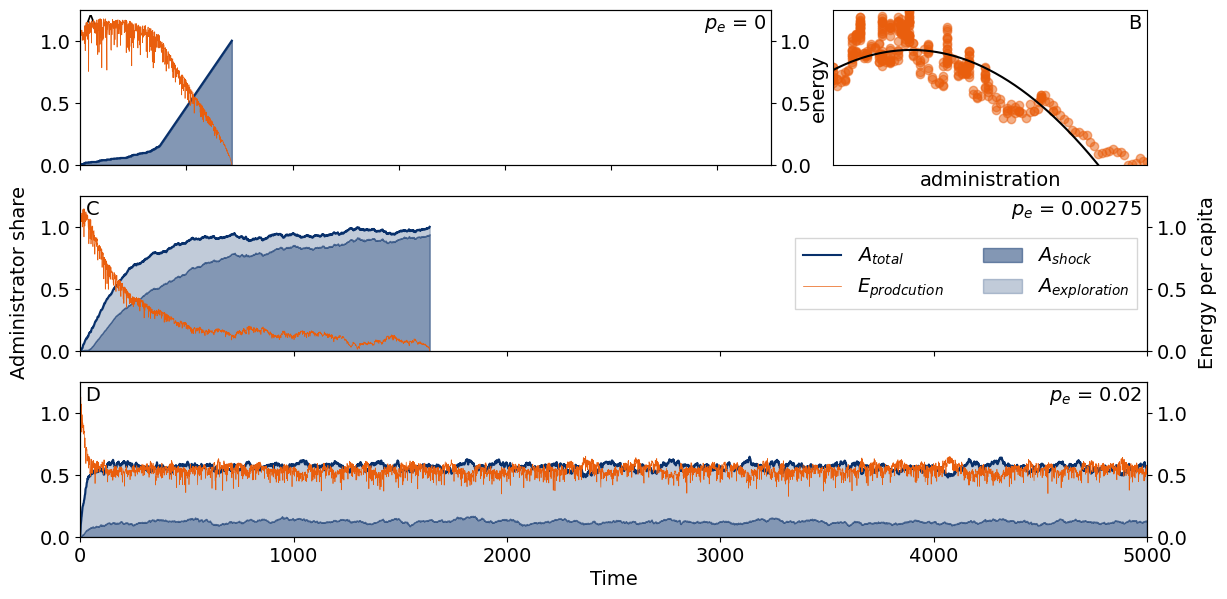

In [7]:
f2 = fig2_stochastic_simulations(
    seed=SEED,
    plot_time=plot_time,
    network_size=network_size,
    rho=rho,
    elasticity_l=elasticity_l,
    elasticity_c=elasticity_c,
    productivity_c=productivity_c,
    exploration_setups=exploration_scenarios,
    shock_alpha=shock_alpha,
    shock_beta=shock_beta
)
plt.show()
f2.savefig(f"{output}/pub_figure2.png", dpi = 65)


## Macroscopic Approximation

the macroscopic approximation is

$\frac{dN_A}{dt}=p_e(N-2 N_A) + F(\frac{N ^ \psi}{E}, \beta, \alpha), with$


$E = ((N-N_a)(1-\rho)^{N_a})^\psi + c((N-N_A)(1-(1-\rho)^{N_A}))^\phi$


$E_{cap} =  \frac{E}{N ^ \psi} $

where $F$ is the cumulative Beta distribution and $N^\psi$ is the initial energy production of the network without any coordinated workers. It implies the assumption that resource of the network increases exponentially with decreasing marginal returns. This is done to satisfy that the initial energy production always satistfy $E_{cap} = 1$


#### Figure 3

/home/flo-schu/projects/tainter/tainter/f3_plot_ensemble_with_approx.py:145: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['', '', '', '', '', ''])


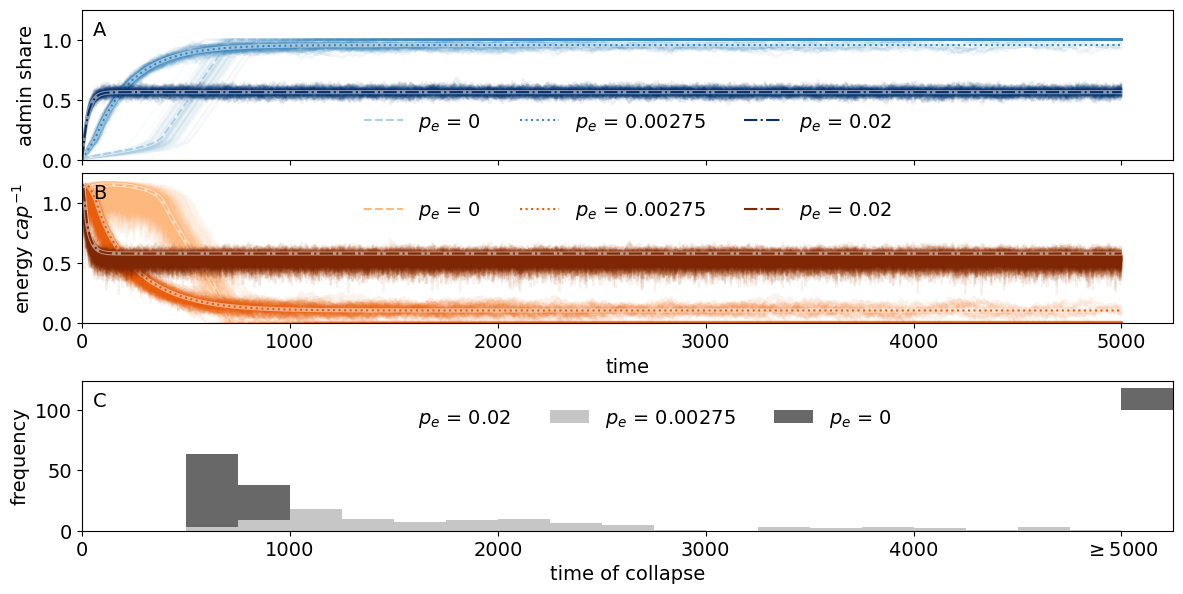

In [21]:
# switch flag use_pre_simulated_data_fig3 to False if a new ensemble should be
# generated.

f3 = fig3_stochastic_ensemble_and_macroscopic_approximation(
    seed=SEED,
    plot_time=plot_time,
    network_size=network_size,
    rho=rho,
    elasticity_l=elasticity_l,
    elasticity_c=elasticity_c,
    productivity_c=productivity_c,
    exploration_setups=exploration_scenarios,
    shock_alpha=shock_alpha,
    shock_beta=shock_beta,
    ensemble_data=ensemble_data,
    iterations=iterations,
    use_pre_simulated_data=use_pre_simulated_data_fig3
)
plt.show()
f3.savefig(f"{output}/pub_figure3.png", dpi = 65)

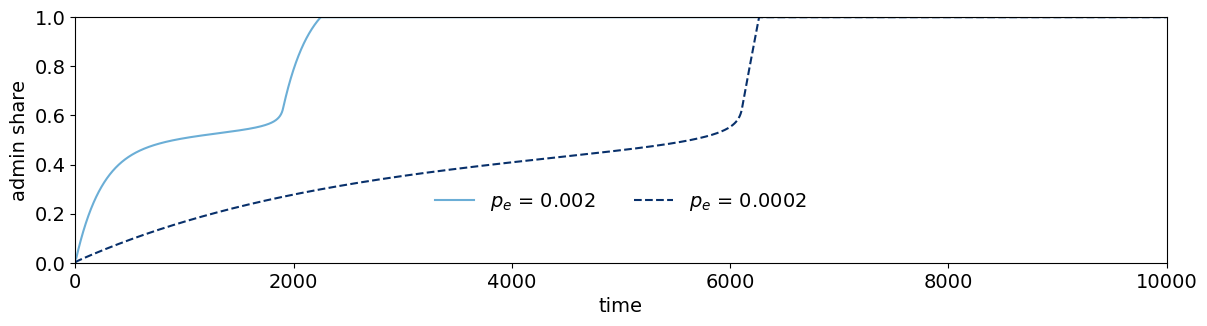

In [9]:
f3b = fig3b_administrator_trajectories(
    exploration_setups=[0.002, 0.0002],
    network_size=network_size,
    rho=0.05,
    elasticity_c=0.75,
    elasticity_l=0.75,
    productivity_c=2.1,
    shock_alpha=shock_alpha,
    shock_beta=shock_beta
)

plt.show()
f3b.savefig(f"{output}/pub_figure3b.png", dpi=65)

## Parameter Analysis of Macroscopic Approximation

|⚡|Running `parameter_scan` takes a long time and is not necessary if the file: `publication_data/parameter_analysis/results_combined_publication.txt` already exists.|
|-|-|

If large scale ranges with millions of parameter combinations should be run
it is better to perform the parameter scan with the shell script `scripts/parameter_analysis/parameter_analysis.sh` on a HPC system with a SLURM engine. 

The true number of parameters to generate the pre-simulated data is defined by:

```python
rho = np.linspace(0, 0.1, 100)  # link density in erdos renyi network
c = np.linspace(1, 3, 200)  # efficiency of coordinated Workers
pe_null = np.array([0])
pe_explore = np.logspace(-5, -1.6, num=499)
p_e = np.concatenate((pe_null, pe_explore), axis=None)
```

In [10]:
# select parameter ranges
rho = np.linspace(0, 0.3, 20)  # link density in erdos renyi network
c = np.linspace(1, 3, 20)      # efficiency of coordinated Workers
pe_null = np.array([0])
pe_explore = np.logspace(-5, -1.6, num=20)
p_e = np.concatenate((pe_null, pe_explore), axis=None)

approx_parameters = dict(
    N=400,
    p_e=None,  # exploration probability
    rho=None,  # link density
    psi=0.75,  # Output elasticity to scale (L)
    phi=0.75,  # Output elasticity to scale (C)
    c=None,    # productivity of C
    alpha=1,   # 
    beta=15
)


parameters, n_chunks = generate_parameters(
    output=par_scan_output,
    approx_parameters=approx_parameters,
    chunk_size=None,
    p_e=p_e,
    rho=rho,
    c=c,
)

creating parameter chunks


100%|██████████| 1/1 [00:00<00:00, 30.68it/s]


In [22]:
# switch flag use_pre_simulated_data_fig4 to False if a new parameter scan 
# should be generated.

if not use_pre_simulated_data_fig4:
    # run parameter scan. 
    parameter_scan(
        output_dir=par_scan_output,
        njob=1,
        parameters=parameters,
        # approximation params
    )

    data = process_output(par_scan_output)
    np.savetxt(par_scan_output + "results_combined.txt", data)

    print(f"prepared parameters {parameters} in {n_chunks} chunks.")

Import complete
10000000 500 100 200


/home/flo-schu/miniconda3/envs/tainter/lib/python3.9/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_child1), but could not find a label for it.
  warnings.warn(


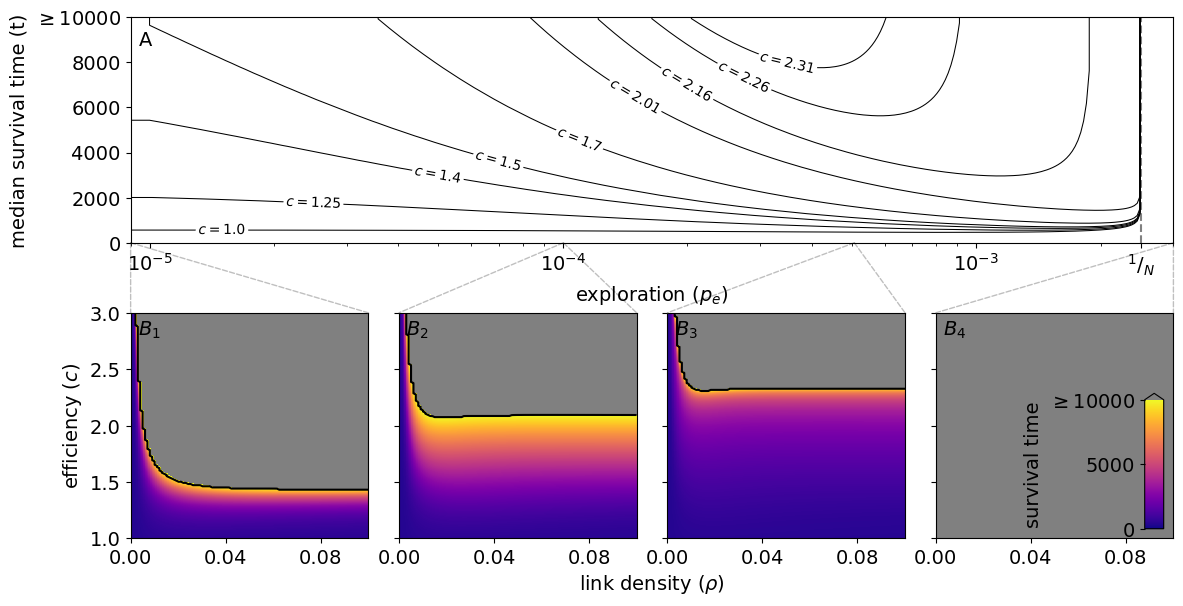

In [24]:
f4 = fig4_parameter_analysis(
    # use 'results_combined.txt' if self generated results should be used
    data_file=f"{par_scan_output}/results_combined_publication.txt",
    parameters=["\\rho", "p_e", "c"],
    panel_steps=[0, 1e-4, 5e-4, 5e-3],
    multiline_steps=[1.0, 1.25, 1.4, 1.5, 1.7, 2.0, 2.15, 2.25,2.3]
)
# postprocess x ticks of lower panels
_ = [ax.set_xticks([0.0, 0.04, 0.08]) for ax in f4.axes[slice(0,4)]]
plt.show()
f4.savefig(f"{output}/pub_figure4.png", dpi=65)